# text2poem
End-to-End Poetry Generation from a list of topics using [T5: Text-To-Text Transfer Transformer](https://arxiv.org/abs/1910.10683)  
Author: [Harshit Varma](https://github.com/hrshtv)



## Install Dependencies

In [1]:
! pip install transformers==4.5.1
! pip install sentencepiece==0.1.94 # Version is important as T5's tokenizer has this version as a dependency 

     |████████████████████████████████| 2.1MB 29.1MB/s 
     |████████████████████████████████| 901kB 37.6MB/s 
     |████████████████████████████████| 3.3MB 41.7MB/s 
     |████████████████████████████████| 1.1MB 35.2MB/s 


## Connect to GDrive

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## Start
To reset the notebook, run from this point

In [166]:
%reset -f

## Import Libraries

In [167]:
# General libraries
import random
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts

# The general framework used
import torch
from torch.utils.data import Dataset, DataLoader

# T5 specific libraries
from transformers.optimization import Adafactor
from transformers import T5Tokenizer, T5ForConditionalGeneration

## Connecting to the GPU

In [168]:
torch.cuda.empty_cache()

In [169]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# See which GPU has been allotted 
print(torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


## Constants

In [170]:
PATH_DATA = "/content/gdrive/MyDrive/text2poem/topics_250_top_authors.csv"
MODEL_NAME = "t5-base"

SEED = 0

# Specified in the number of tokens
INP_MAX_LEN = 128
OUT_MAX_LEN = 512

TRAIN_BATCH_SIZE = 4

N_EPOCHS = 10
LR = 1e-4

PREFIX = "poemify: " # The T5 prefix to append to the inputs
SENT_SEP = "|" # All newlines/multi-newlines are replaced by a single '|' as T5Tokenizer replaces "\n" by a space
TOPIC_SEP = ", " # Delimiter used for separating the topics in the input

In [171]:
# Set random seeds and make pytorch deterministic for reproducibility
# Reference: https://github.com/NVIDIA/framework-determinism/blob/master/pytorch.md
def setSeed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
setSeed()

## Helper Functions

In [172]:
def countParameters(model):
    """ Counts the total number of trainable and frozen/non-trainable parameters in the model """
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
    return trainable, frozen

## Custom Dataset

In [173]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer, inp_len, out_len):

        self.tokenizer = tokenizer
        self.df = df

        self.inp_len = inp_len # All input sequences would be padded to this length
        self.out_len = out_len # All output sequences would be padded to this length

        self.inp_txt = self.df.input
        self.out_txt = self.df.output


    def __len__(self):
        return len(self.out_txt)


    def __getitem__(self, index):

        inp_txt = str(self.inp_txt[index])
        out_txt = str(self.out_txt[index])

        # Encode the input and output texts
        source = self.tokenizer(
            [inp_txt],
            max_length = self.inp_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        target = self.tokenizer(
            [out_txt],
            max_length = self.out_len, 
            padding = "max_length", 
            truncation = True,
            return_tensors = "pt"
        )

        # Input IDs and Masks
        source_ids = source["input_ids"].squeeze() # squeeze() to remove the additional dimension
        source_mask = source["attention_mask"].squeeze()
        target_ids = target["input_ids"].squeeze()
        target_mask = target["attention_mask"].squeeze()

        # Don't shift the inputs/outputs to GPU now, do it while loading the batches, and then shift the entire batch at once

        return {
            "source_ids"  : source_ids, 
            "source_mask" : source_mask, 
            "target_ids"  : target_ids,
            "target_mask" : target_mask
        }

## Data Handlers

In [174]:
def replaceSep(text, sep = SENT_SEP):
    """ Replaces all signle/multi-linebreaks by a single 'sep' everywhere, as T5Tokenizer just replaces '\n' by a blank space """
    corrupted_sentences = text.split("\n")
    sentences = [s.strip() for s in corrupted_sentences if len(s.strip()) > 1] # Only keep sentences of length > 1
    text = sep.join(sentences)
    return text

In [175]:
def loadDF(path, n_rows = None, prefix = PREFIX):
    """ Loads the CSV data, converts it to the specified format, and splits it into training and validation sets """

    # Read the CSV file
    df = pd.read_csv(PATH_DATA, encoding = "utf-8")

    # Drop the NaN rows (if any)
    df.dropna(inplace = True)

    # Choose the approproate columns containing the text input and the text output
    df = df[["Content", "Topics"]]

    # Rename the columns appropriately (dataset specific)
    df.rename(columns={"Content" : "output", "Topics" : "input"}, inplace=True)

    # Add a suitable prefix to the text input
    df["input"] = prefix + df["input"]

    # Truncate the dataset if specified
    if n_rows is not None:
        df = df.sample(n = n_rows, random_state = SEED)

    # Replace newlines in the poem
    df["output"] = df["output"].apply(replaceSep)

    # Train-Test Split
    df_train, df_val = tts(df, test_size = 5, random_state = SEED, shuffle = True)
    
    # Reset indices
    df_train.reset_index(drop = True, inplace = True)
    df_val.reset_index(drop = True, inplace = True)

    return df, df_train, df_val

In [176]:
def getDataLoaders(df_train, df_val, tokenizer):
    """ Returns the torch DataLoaders for the training and validation DFs """

    # Create Datasets
    ds_train = CustomDataset(df_train, tokenizer, INP_MAX_LEN, OUT_MAX_LEN)
    ds_val   = CustomDataset(df_val, tokenizer, INP_MAX_LEN, OUT_MAX_LEN)

    # Create Dataloaders
    dl_train = DataLoader(ds_train, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)
    dl_val   = DataLoader(ds_val, batch_size = TRAIN_BATCH_SIZE, shuffle = True, num_workers = 0)

    return dl_train, dl_val

## Train and Validate Functions

In [177]:
def train(tokenizer, model, loader, optimizer):
    """ A single epoch """

    model.train()

    loss_batches = []

    for iter, batch in enumerate(tqdm(loader)):

        # Reset gradients
        optimizer.zero_grad()

        source_ids  = batch["source_ids"].to(DEVICE)
        source_mask = batch["source_mask"].to(DEVICE)
        target_mask = batch["target_mask"].to(DEVICE)

        labels = batch["target_ids"]
        labels[labels[:, :] == tokenizer.pad_token_id] = -100
        labels = labels.to(DEVICE)

        outputs = model(
            input_ids = source_ids, 
            attention_mask = source_mask, 
            labels = labels,
            decoder_attention_mask = target_mask
        ) # Of type Seq2SeqLMOutput

        loss = outputs.loss
        
        loss_batches.append(loss.item())

        # Compute gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()

    # Average epoch loss:
    avg_epoch_loss = sum(loss_batches) / len(loss_batches)

    return avg_epoch_loss

## Generation

In [178]:
def genSample(topics, min_length, max_length, rep_penalty = 1, temp = 1, top_k = 50, top_p = 1.0, already_formatted = False):

    setSeed() # Required to ensure reproducibility

    if not already_formatted:
        input = PREFIX + TOPIC_SEP.join(topics)
    else:
        input = topics

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(
            do_sample = True,
            input_ids = input_ids,
            min_length = min_length,
            max_length = max_length,
            top_p = top_p,
            top_k = top_k,
            temperature = temp,
            repetition_penalty = rep_penalty
        )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split(SENT_SEP)
    for s in sentences:
        print(s.strip())

    return gen

In [179]:
def genBeam(topics, min_length, max_length, rep_penalty = 1, n_beams = 2, no_repeat_ngram_size = 3, already_formatted = False):

    setSeed() # Required to ensure reproducibility

    if not already_formatted:   
        input = PREFIX + TOPIC_SEP.join(topics)
    else:
        input = topics

    input_ids = tokenizer(
        input,
        return_tensors = "pt"
    ).input_ids.to(DEVICE)

    model.eval()
    with torch.no_grad():
        generated_ids = model.generate(
            input_ids = input_ids,
            min_length = min_length,
            max_length = max_length,
            num_beams = n_beams,
            no_repeat_ngram_size = no_repeat_ngram_size, # Don't repeat any n-grams of this size
            repetition_penalty = rep_penalty
        )

    gen = [tokenizer.decode(g, skip_special_tokens = True, clean_up_tokenization_spaces = True) for g in generated_ids][0]

    sentences = gen.split(SENT_SEP)
    for s in sentences:
        print(s.strip())

    return gen

## Main

### Tokenizer

In [180]:
# T5's Tokenzier for encoding the text
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)

In [181]:
example_text = "Far far away, behind the word mountains, far from the countries Vokalia and Consonantia, there live the blind texts.\nFar far away, behind the word mountains, far from the countries Vokalia and Consonantia, there live the blind texts"
example_input_ids = tokenizer(
    example_text,
    return_tensors = "pt"
).input_ids[0]
print(len(example_input_ids))
example_decoded = [tokenizer.decode(i, skip_special_tokens = True, clean_up_tokenization_spaces = True) for i in example_input_ids]
print(example_decoded)

56
['Far', 'far', 'away', ',', 'behind', 'the', 'word', 'mountains', ',', 'far', 'from', 'the', 'countries', 'Vo', 'k', 'alia', 'and', 'Cons', 'on', 'anti', 'a', ',', 'there', 'live', 'the', 'blind', 'texts', '.', 'Far', 'far', 'away', ',', 'behind', 'the', 'word', 'mountains', ',', 'far', 'from', 'the', 'countries', 'Vo', 'k', 'alia', 'and', 'Cons', 'on', 'anti', 'a', ',', 'there', 'live', 'the', 'blind', 'texts', '</s>']


### Loading the Data

In [182]:
df, df_train, df_val = loadDF(PATH_DATA, prefix = PREFIX)
print(len(df), len(df_train), len(df_val))

566 561 5


In [183]:
display(df)

,output,input
0,"Of old sat Freedom on the heights,|The thunder...","poemify: fair form, triple forks, starry light..."
1,"Contemplate all this work of Time,|The giant l...","poemify: tiger die, central gloom, solid earth..."
2,"Is it, then, regret for buried time|That keenl...","poemify: happy commune, sorrow lives, strong b..."
3,"Calm is the morn without a sound,|Calm as to s...","poemify: deep peace, dead calm, calmer grief, ..."
4,"Ring out, wild bells, to the wild sky,|The fly...","poemify: happy bells, kindlier hand, party str..."
...,...,...
561,Milton! thou shouldst be living at this hour:|...,"poemify: heroic wealth, cheerful godliness, se..."
562,Earth has not anything to show more fair:|Dull...,"poemify: dear god, smokeless air, river glidet..."
563,"The power of Armies is a visible thing,|Formal...","poemify: fatal place, brave people, strong win..."
564,"I heard a thousand blended notes,|While in a g...","poemify: pleasant thoughts, sweet mood, fair w..."


In [184]:
dl_train, dl_val = getDataLoaders(df_train, df_val, tokenizer)
print(len(dl_train), len(dl_val))

141 2


In [185]:
def countTokens(text):
    input_ids = tokenizer(
        text,
        return_tensors = "pt"
    ).input_ids[0]
    return len(input_ids)

In [186]:
df["input_length"] = df["input"].apply(countTokens)
df["output_length"] = df["output"].apply(countTokens)

In [187]:
# Use this to select INP_MAX_LEN and OUT_MAX_LEN
print("Input Length (in tokens) Statistics")
print(df["input_length"].describe())
print()
print("Output Length (in tokens) Statistics")
print(df["output_length"].describe())

Input Length (in tokens) Statistics
count    566.000000
mean      44.510601
std       11.159300
min       13.000000
25%       36.000000
50%       43.000000
75%       51.000000
max      107.000000
Name: input_length, dtype: float64

Output Length (in tokens) Statistics
count    566.000000
mean     227.250883
std       91.590512
min       73.000000
25%      166.000000
50%      201.000000
75%      287.000000
max      497.000000
Name: output_length, dtype: float64


### Loading the Model

In [188]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
model = model.to(DEVICE)

In [189]:
p_train, p_frozen = countParameters(model)
print(f"The model has {p_train:,} trainable and {p_frozen:,} frozen parameters")

The model has 222,903,552 trainable and 0 frozen parameters


### Optimization

In [190]:
optimizer = Adafactor(
    params = model.parameters(),
    lr = LR,
    scale_parameter = False,
    relative_step = False
)

In [191]:
losses = []
for e in range(N_EPOCHS):
    print(f"Epoch {e+1}/{N_EPOCHS}")
    loss_epoch = train(tokenizer, model, dl_train, optimizer)
    losses.append(loss_epoch)

Epoch 1/10



Epoch 2/10



Epoch 3/10



Epoch 4/10



Epoch 5/10



Epoch 6/10



Epoch 7/10



Epoch 8/10



Epoch 9/10



Epoch 10/10


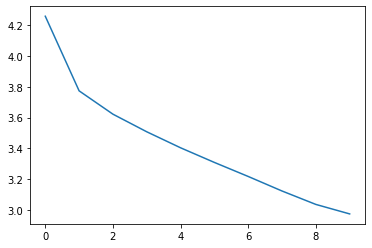

In [192]:
plt.plot(range(len(losses)), losses)
plt.show()

### Generation

In [199]:
val_list = df_val["input"].tolist()
for inp in val_list:
    print(f"Input: {inp}")
    genSample(
        topics = inp, 
        min_length = 50, 
        max_length = 500, 
        rep_penalty = 1.5, 
        temp = 0.9, 
        top_k = 50,
        top_p = 1.0, 
        already_formatted = True
    )
    print("\n\n")

Input: poemify: devil curse, pity peace, reapd grain, mown hay, heavy rain, poor, miseries, heavens, happy, worlds, springing, singing
The rains are coming;
And heavens have long been happy:
Whose world was ruined by the devil curse,
Too heavy in rain and snow.
Nobody had springing to sing!
No one shall sing more of their miseries.
No man who singth is so happy as to kiss.
He will not leave with a devil curse



Input: poemify: cheerful homage, frighted sheep, standing pools, sov'reign pow, journey lay, ev'ry mountain, deep divides, deep divide, tremble, hand, fright, adore, word, tyrant, tribes
The day comes to her;
And she has heard the words,
And hath heard the tyrant say:
They have learned the word,
The way of thee not.
Then had she come and said, "No more!"
"You were a tyrant."
"No more shall we go?"
"Be at hand, be by me!"
"Beatle on the deep divides,
Sov'reign pow!"
"No more shall we go?
To cross the river,-
No more will we reach.
"But all our journey lie;
We must dare to cross 

In [198]:
for inp in val_list:
    print(f"Input: {inp}")
    genBeam(
        topics = inp,
        min_length = 50,
        max_length = 500,
        rep_penalty = 1.5, 
        n_beams = 8, 
        no_repeat_ngram_size = 3, 
        already_formatted = True
    )
    print("\n\n")

Input: poemify: devil curse, pity peace, reapd grain, mown hay, heavy rain, poor, miseries, heavens, happy, worlds, springing, singing
There is a devil curse on earth,
And heavens are happy with springing rain.
There is no heavy rain on earth;
But pity peace in heavens.
It is the devil's curse,
The reapd grain, the mown hay,
All the miseries of the worlds;
And there is no devil to curse.
No devil can curse thee,
Nor doth he curse me



Input: poemify: cheerful homage, frighted sheep, standing pools, sov'reign pow, journey lay, ev'ry mountain, deep divides, deep divide, tremble, hand, fright, adore, word, tyrant, tribes
O tyrant of the tribes!
O lord of the nations!
Which wilt thou adore?
Have you not heard thee?
Would you not hear thee speak?
Are you not listening to me?
Did you know what I am saying?
Yet did you not know that I am speaking?
It was a joyful homage,
And a sov'reign pow!
Then came the journey lay in the deep divides,
Where the frighted sheep are standing pools



Input: 

In [195]:
gen = genSample(
    topics = ["frosty white", "candy cane", "jolly carols", "celebration", "gingerbread", "mistletoe", "snowflakes"], 
    min_length = 50, 
    max_length = 500, 
    rep_penalty = 1.5,
    temp = 0.9,
    top_k = 50,
    top_p = 1, 
    already_formatted = False
)

The day is a frosty white!
What if the snowflakes had fallen on the tree?
Who cares but to look at the Christmas celebration?
None could help but wonder,
That was the day of the jolly carols.
And twigs in the mistletoe were flying off.
It seemed to me that I was wearing it:
And then all my jolly carols were falling;
And now I sing with joy
When I heard the gingerbread man and gingerbread-
No sugar canon...No candy Cane


In [197]:
gen = genSample(
    topics = ["dark woods", "weeping river", "full moon", "freezing air", "vengeance"],
    min_length = 50, 
    max_length = 500, 
    rep_penalty = 1.5, 
    temp = 0.9, 
    top_k = 50, 
    top_p = 1, 
    already_formatted = False
)

The day is coming;
O you, the poet!
Sweet and warm in the dark woods of the Alps.
Are you going with me? I'll be gone to bed:
I'll fly away to a full moon.
O you, Lord! my days are over.
O king! your days are long since done.
And yet I hope to return here.
Or may one day that for us would be gone forever.
When we turn from dark wood or night into vengeance,
When the full moon comes out like a snow-blue mountain,
Weeping river before the full moon


## Prevent Colab Timeout
After setting the model on training, use inject the following JS code into the console to prevent losing connection after 90 mins. This code keeps adding new cells every 30 mins, so make sure to select the last cell before injection, after training, delete all these cells manually.
```javascript
var t_interval = 1800; // In seconds, 30 mins
function AddCell(){
    console.log("Added cell"); 
    document.querySelector("#toolbar-add-code").click() 
}
setInterval(AddCell, t_interval*1000); // this is in ms, thus multiplied by 1000 
```